# Delaware Case Study
## Simple Model of SGD



In [24]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

#Name model
modelname = 'test2'

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy
import SGD

print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('flopy version: {}'.format(flopy.__version__))

if sys.platform == "darwin":
    model_ws = os.path.join('/Users/ianpg/Documents/ProjectsLocal/DelawareSGD','work',modelname)
elif sys.platform == "win32":
    model_ws = os.path.join('E:\Projects\DelawareSGD','work',modelname)    

if not os.path.exists(model_ws):
    os.makedirs(model_ws)
sys.path.append(os.path.join(model_ws,'..','..'))
import config
sw_exe = config.swexe

os.listdir(model_ws)

print('Model workspace:',os.path.abspath(model_ws))

3.5.5 |Anaconda 4.2.0 (64-bit)| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]
numpy version: 1.15.0
flopy version: 3.2.9
Model workspace: E:\Projects\DelawareSGD\work\test2


In [25]:
#Other functions and imports

#nearest value in array
def find_nearest(array,value):
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    idx.astype('int')
    return array[idx]

#take distance in meters, return column in model
def loc_to_col(locs):
    cols = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in locs]
    return cols

In [26]:
#Model grid
#Grid: 0.5 *1*1m • Size:70m*20m
        
Lx = 70.
Lz = 20.
nlay = 40
nrow = 3
ncol = 70
delr = Lx / ncol
delc = 1.0
delv = Lz / nlay
henry_top = Lz
henry_botm = np.linspace(henry_top - delv, 0., nlay)

#Period data
nper = 1
perlen = [100]
nstp = [100]
steady = [True]
itmuni = 4 #time unit 4= days
lenuni = 2 #length unit 2 = meter
tsmult = 1
ssm_data = None
verbose=True


In [27]:
#Create basic model instance and dis pacakge
m = flopy.seawat.Seawat(modelname, exe_name=sw_exe, model_ws=model_ws,verbose=verbose)
SGD.ModelSGD.Seawat2SGD(m)
print(m.namefile)

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(m, nlay, nrow, ncol, nper=nper, delr=delr,
                               delc=delc, laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=perlen, nstp=nstp,
                               steady=steady,itmuni=itmuni,lenuni=lenuni,
                               tsmult=tsmult)

test2.nam
adding Package:  DIS


In [28]:
#Hydraulic conductivity field 

hkSand = 80.  #horizontal hydraulic conductivity m/day
hkClay = 1. 
lithmat = hkSand*np.ones((nlay,nrow,ncol), dtype=np.int32) #sandy background
addclay_yn = 1


def rand_clay_blocks(lithmat,hkClay,numblocks,sizeblocks):
    nlay,nrow,ncol = lithmat.shape
    lay_block = np.random.randint(1,nlay-sizeblocks[0],numblocks)
    row_block = np.random.randint(0,nrow-sizeblocks[1]+1,numblocks)
    col_block = np.random.randint(1,ncol-sizeblocks[2],numblocks)
    lithmat_blocks = lithmat.copy()
    for i in range(numblocks):
        block_coords = [slice(lay_block[i],lay_block[i]+sizeblocks[0]),
                        slice(row_block[i],row_block[i]++sizeblocks[1]),
                        slice(col_block[i],col_block[i]+sizeblocks[2])]
        lithmat_blocks[block_coords] = hkClay
    return lithmat_blocks

#add low conductivity regions
if addclay_yn == 1:
    lithmat = rand_clay_blocks(lithmat,hkClay,100,(2,2,5))
low_k_loc = (20,30)
low_k_col = loc_to_col(low_k_loc)
#lithmat[1:3,0,0:65] = hkClay

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [29]:
#Set Hydraulic properties

hk = lithmat
sy = 0.15
ss = 0.00005
por = 0.2
vka = 1/10 # = vk/hk
al = 3 #longitudinal dispersivity, in m
#dmcoef = 0.57024 #m2/day  Could also try 1.62925 as another case of the Henry problem
dmcoef = 0. #test for numerical dispersion

#Variable density parameters
Csalt = 35.0001
Cfresh = 0.
densesalt = 1025.
densefresh = 1000.
denseslp = (densesalt - densefresh) / (Csalt - Cfresh)

In [30]:
#BCs
calc_inland_head = 1 #don't calculate from hgrad
manual_inland_head = Lz + .1
ocean_head = Lz
start_fresh_yn = 0

# save cell fluxes to unit 53
ipakcb = 53

#MODFLOW BCs
hgrad = 0.0033 #hydraulic gradient, m/m
qinflow = 0  #influent FW m3/day

#Create ocean boundary at top of model
ocean_loc = [30,70] # location of ocean [start,end] in m
ocean_col = [int(find_nearest((np.arange(ncol)*delc),loc)) for loc in ocean_loc]
ocean_col_vec = (0,0,np.arange(ocean_col[0],ocean_col[1]+1))
ocean_coords = (0,slice(0,nrow),slice(ocean_col[0],ocean_col[1]+1)) #top of the model
ocean_bool = np.zeros((nlay,nrow,ncol), dtype=bool)
ocean_bool[0,:,np.arange(ocean_col[0],ocean_col[1]+1)] = 1

if calc_inland_head ==1:
    head_inland = ocean_loc[0]*hgrad + Lz
else:
    head_inland = manual_inland_head


#Set ibound
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1 #first column (FW boundary) has fixed head
ibound[ocean_bool] = -1
ibound[0:2,:,ocean_col[0]-3:ocean_col[0]] = 0

#Set starting heads
strt = head_inland*np.ones((nlay, nrow, ncol)) #starting heads (for fixed head BC, this is will assign the head)
strt[ocean_bool] = ocean_head #head of ocean boundary

#Transport BCs
if start_fresh_yn == 1:
    sconc = Cfresh*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin fresh
elif start_fresh_yn == 0:
    sconc = Csalt*np.ones((nlay, nrow, ncol), dtype=np.float32) #Begin SW-saturated

sconc[ocean_bool] = Csalt
sconc[:,:,0] = Cfresh

icbund = np.ones((nlay, nrow, ncol), dtype=np.int) 
icbund[(ibound < 0)] = -1 #constant concentration cells where also constant head


In [31]:
#Create instances in flopy

bas = flopy.modflow.ModflowBas(m, ibound, strt=strt)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(m, hk=hk, vka=vka, ipakcb=ipakcb, ss=ss, sy=sy)

# Add PCG Package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(m, hclose=1.e-8)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(m,
                             stress_period_data={(0, 0): ['save head', 'save budget']},
                             compact=True)
#wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_data, ipakcb=ipakcb)

#Create the basic MT3DMS model structure
btn = flopy.mt3d.Mt3dBtn(m, 
                         #nlay=nlay, nrow=nrow, ncol=ncol, nper=nper, 
                         laycon=lpf.laytyp, htop=henry_top, 
                         dz=dis.thickness.get_value(), prsity=0.2, icbund=icbund,
                         sconc=sconc, nprs=-10)
adv = flopy.mt3d.Mt3dAdv(m, mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(m, al=al, trpt=1., trpv=1., dmcoef=dmcoef)
gcg = flopy.mt3d.Mt3dGcg(m, iter1=500, mxiter=1, isolve=1, cclose=1e-7)
ssm = flopy.mt3d.Mt3dSsm(m, stress_period_data=ssm_data)

#vdf = flopy.seawat.SeawatVdf(m, iwtable=0, densemin=0, densemax=0,denseref=1000., denseslp=0.7143, firstdt=1e-3)
vdf = flopy.seawat.SeawatVdf(m, mtdnconc=1, mfnadvfd=1, nswtcpl=0, iwtable=0, 
                             densemin=0., densemax=0., denseslp=denseslp, denseref=densefresh)


adding Package:  BAS6
Adding test2.cbc (unit=53) to the output list.
adding Package:  LPF
adding Package:  PCG
Adding test2.hds (unit=51) to the output list.
adding Package:  OC
adding Package:  BTN
adding Package:  ADV
adding Package:  DSP
adding Package:  GCG
adding Package:  SSM
adding Package:  VDF


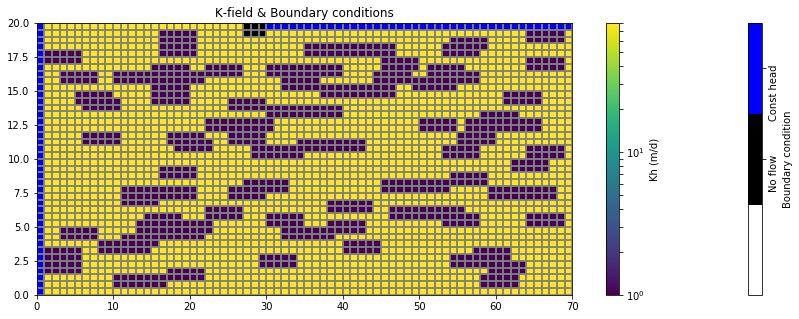

In [32]:
# Make plot of the grid
f = plt.figure(figsize=(15, 5))
plt.clf()
ax = f.add_subplot(1, 1, 1)
mm = flopy.plot.ModelCrossSection(ax=ax, model=m, line={'row':1});
hkpatchcollection = mm.plot_array(hk, norm=matplotlib.colors.LogNorm(),vmin=hkClay, vmax=hkSand);
linecollectdsion = mm.plot_grid();
patchcollection = mm.plot_ibound();
cb = plt.colorbar(patchcollection);
cb.set_label('Boundary condition',rotation=90)

cb.set_ticks((1.5,2.5))
#cb.set_ticklabels(('No flow','Const head'))
cb.ax.set_yticklabels(('No flow','Const head'),rotation=90)


cb2 = plt.colorbar(hkpatchcollection,ax=ax);
cb2.set_label('Kh (m/d)', rotation=90)
plt.title('K-field & Boundary conditions');

In [33]:
#Write input
m.write_input()

# Try to delete the output files, to prevent accidental use of older files
try:
    os.remove(os.path.join(model_ws,'MT3D.CNF'))
    os.remove(os.path.join(model_ws,'MT3D001.MAS'))
    os.remove(os.path.join(model_ws, 'MT3D001.UCN'))
    os.remove(os.path.join(model_ws, modelname + '.hds'))
    os.remove(os.path.join(model_ws, modelname + '.cbc'))
except:
    pass


Writing packages:
   Package:  DIS
   Package:  BAS6
   Package:  LPF
   Package:  PCG
   Package:  OC
   Package:  BTN
   Package:  ADV
   Package:  DSP
   Package:  GCG
   Package:  SSM
   Package:  VDF
 


In [34]:
#Run model
v = m.run_model(silent=False, report=True)
for idx in range(-3, 0):
    print(v[1][idx])

FloPy is using the following executable to run the model: E:\Projects\DelawareSGD\bin\win64\swt_v4.exe

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulting from their authorized or unauthorized
 use.


 Using NAME file: test2.nam                                                                                                                                                                                               
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/08/28 13:18:26


 STRESS PERIOD NO.    1



## Post-processing results

In [35]:
#Post-processing functions
def plotdischarge(modelname,model_ws,color='w',kstpkper_ind=-1,scale=50):
    fname = os.path.join(model_ws, '' + modelname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname)
    qx = budobj.get_data(text='FLOW RIGHT FACE')[kstpkper_ind]
    qz = budobj.get_data(text='FLOW LOWER FACE')[kstpkper_ind]
    
    # Average flows to cell centers
    qx_avg = np.empty(qx.shape, dtype=qx.dtype)
    qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
    qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
    qz_avg = np.empty(qz.shape, dtype=qz.dtype)
    qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
    qz_avg[0, :, :] = 0.5 * qz[0, :, :]
    
    y, x, z = dis.get_node_coordinates()
    X, Z = np.meshgrid(x, z[:, 0, 0])
    iskip = 1 #how many cells to skip, 1 means plot every cell
    
    ax = plt.gca()
    cpatchcollection = ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
              qx_avg[::iskip, 0, ::iskip], -qz_avg[::iskip, 0, ::iskip],
              color=color, scale=scale, headwidth=4, headlength=2,
              headaxislength=1, width=0.0025)
    return cpatchcollection

def permute_kstpkper(ucnobj):
    kstpkper = ucnobj.get_kstpkper()
    kstpkper_unique = []
    index_unique = []
    niter = 0
    for entry in kstpkper:
        if not entry in kstpkper_unique:
            kstpkper_unique.append(entry)
            index_unique.append(niter)
        niter += 1
    return kstpkper_unique, index_unique

def kstpkper_from_time(ucnobj,tottim):
    kstpkpers = ucnobj.get_kstpkper()
    times = ucnobj.get_times()
    timeind = times.index(tottim)    
    kstpkper = kstpkpers[timeind]
    return kstpkper

def kstpkper_ind_from_kstpkper(ucnobj,kstpkper=(0,0)):
    kstpkpers = ucnobj.get_kstpkper()
    kstpkper_unique = permute_kstpkper(ucnobj)[0]
    kstpkper_ind = kstpkper_unique.index(kstpkper)
    return kstpkper_ind



def get_salt_outflow(m,ocean_coords,totim=None):
    fname = os.path.join(m.model_ws, 'MT3D001.UCN')
    ucnobj = flopy.utils.binaryfile.UcnFile(fname)
    if times==None:
        totim = ucnobj.get_times()[-1]
    ocean_conc = ucnobj.get_data(totim=totim)[ocean_coords]
    return ocean_conc
    
def plot_background(mm,array,label=None):
    if label==None:
        label = [ k for k,v in locals().items() if v is array][0]
    cpatchcollection = mm.plot_array(array,cmap='jet')
    cpatchcollection.set_label(label)
    return cpatchcollection,label

In [36]:
#Post-processing functions
def plotdischarge(modelname,model_ws,color='w',kstpkper_ind=-1,scale=50):
    fname = os.path.join(model_ws, '' + modelname + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname)
    qx = budobj.get_data(text='FLOW RIGHT FACE')[kstpkper_ind]
    qz = budobj.get_data(text='FLOW LOWER FACE')[kstpkper_ind]
    
    # Average flows to cell centers
    qx_avg = np.empty(qx.shape, dtype=qx.dtype)
    qx_avg[:, :, 1:] = 0.5 * (qx[:, :, 0:ncol-1] + qx[:, :, 1:ncol])
    qx_avg[:, :, 0] = 0.5 * qx[:, :, 0]
    qz_avg = np.empty(qz.shape, dtype=qz.dtype)
    qz_avg[1:, :, :] = 0.5 * (qz[0:nlay-1, :, :] + qz[1:nlay, :, :])
    qz_avg[0, :, :] = 0.5 * qz[0, :, :]
    
    y, x, z = dis.get_node_coordinates()
    X, Z = np.meshgrid(x, z[:, 0, 0])
    iskip = 1 #how many cells to skip, 1 means plot every cell
    
    ax = plt.gca()
    cpatchcollection = ax.quiver(X[::iskip, ::iskip], Z[::iskip, ::iskip],
              qx_avg[::iskip, 0, ::iskip], -qz_avg[::iskip, 0, ::iskip],
              color=color, scale=scale, headwidth=4, headlength=2,
              headaxislength=1, width=0.0025)
    return cpatchcollection


#Temporarily removed... the 'constant head' data doesn't seem right...
def get_ocean_outflow(m,ocean_col):
    fname = os.path.join(m.model_ws, m.name + '.cbc') 
    budobj = flopy.utils.CellBudgetFile(fname)
    ch = budobj.get_data(text='CONSTANT HEAD')
    ocean_col_vec = np.arange(ocean_col[0],ocean_col[1]+1)
    ocean_nodes = np.ravel_multi_index([np.zeros(ocean_col_vec.size,dtype=int), #nodes in constant head flow file are 1-based
                                      np.zeros(ocean_col_vec.size,dtype=int),   #create a list of node numbers for ocean cells
                                      ocean_col_vec],
                                     (m.dis.nlay,m.dis.nrow,m.dis.ncol)) + 1
    
    ocean_flow =  [ch[-1]['q'][i] for i,node in enumerate(ch[-1]['node']) if node in ocean_nodes]
    tot_flow = np.sum(ocean_flow)
    return flow

In [37]:
# Extract heads
fname = os.path.join(model_ws, '' + modelname + '.hds')
hdobj = flopy.utils.binaryfile.HeadFile(fname)
times = hdobj.get_times()
hds = hdobj.get_data(totim=times[-1])
hds[np.where(ibound != 1)] = np.nan

# Extract salinity
fname = os.path.join(model_ws, 'MT3D001.UCN')
ucnobj = flopy.utils.binaryfile.UcnFile(fname)
times = ucnobj.get_times()
conc = ucnobj.get_data(totim=times[-1])
conc[np.where(ibound != 1)] = np.nan


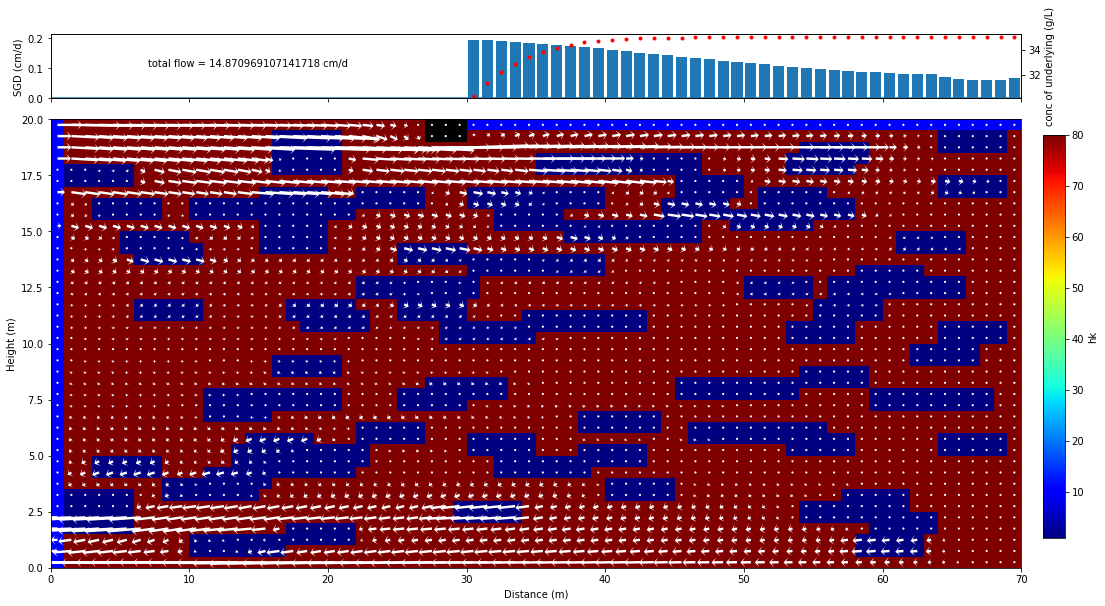

In [108]:
# Make head and quiver plot
import utils
printyn = 0
rowslice = 1
f, axs = plt.subplots(2,1, sharex=True, figsize=(15, 8),
                     gridspec_kw = {'height_ratios':[1, 7]})
plt.tight_layout()

#Plot discharge and ibound
mm = flopy.plot.ModelCrossSection(ax=axs[1], model=m, line={'row':rowslice})
cpatchcollection,label = plot_background(mm,hk,'hk')
mm.plot_ibound()
plotdischarge(m.name,m.model_ws,color='white',kstpkper_ind=-1,scale=1);
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')

#plot SGD
ocean_flow = 100 * np.asarray(utils.get_ocean_outflow_chd(m,ocean_bool))

plt.sca(axs[0]) #set current axes
plt.bar(np.arange(ocean_col[0],ocean_col[1]+1)+delc/2,
        ocean_flow[:,rowslice,:][ocean_bool[:,rowslice,:]])
axs[0].axhline()
axs[0].set_ylim(np.min(ocean_flow)*0.9,np.max(ocean_flow)*1.1)
plt.ylabel('SGD (cm/d)')
axs[0].annotate('total flow = ' + str(np.sum(ocean_flow)) + ' cm/d', xy=(.1,.5),
            xytext=(0.1, 0.5), xycoords='axes fraction', textcoords='axes fraction')

#Plot salt content of cells beneath outflow
ocean_below_vec = (ocean_col_vec[0]+1,) +ocean_col_vec[1:]
ocean_salt_outflow = get_salt_outflow(m,ocean_below_vec)
axs02 = axs[0].twinx()
plt.plot(ocean_col_vec[2]+delc/2 , ocean_salt_outflow,'r.')
#axs02.set_ylim(0,Csalt)

plt.ylabel('conc of underlying (g/L)')

#align plots and set colorbar
f.subplots_adjust(right=0.93)
cbar_ax = f.add_axes([0.95, 0.1, 0.02, 0.7])
cb = f.colorbar(cpatchcollection,cax=cbar_ax)
cb.set_label(label)
if printyn == 1:
    plt.savefig(os.path.join(model_ws, modelname + '_flow_vectors.png'),dpi=300)
plt.show()


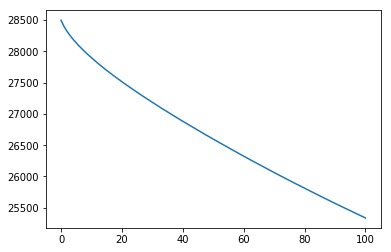

In [39]:
# Load the mas file and make a plot of total mass in aquifer versus time
fname = os.path.join(model_ws, 'MT3D001.MAS')
mas = flopy.mt3d.Mt3dms.load_mas(fname)
f = plt.figure()
ax = f.add_subplot(1, 1, 1)
lines = ax.plot(mas.time, mas.total_mass)
mas[0]
plt.show()

In [118]:
ocean_flow[ocean_bool]

array([0.19334144, 0.19245768, 0.19081964, 0.18854112, 0.18572239,
       0.18245218, 0.17880937, 0.17486409, 0.17067858, 0.16630824,
       0.16180261, 0.15720627, 0.15255968, 0.14789988, 0.14325931,
       0.13866483, 0.13413792, 0.1296951 , 0.1253482 , 0.12110472,
       0.11696828, 0.11293913, 0.10901511, 0.10519479, 0.10148834,
       0.09795937, 0.09466463, 0.09163886, 0.08890042, 0.08645723,
       0.08431543, 0.08248777, 0.08102328, 0.08004286, 0.06813862,
       0.05793304, 0.0540058 , 0.05401835, 0.05886068, 0.06615928,
       0.19334143, 0.19245767, 0.19081963, 0.18854106, 0.18572224,
       0.18245183, 0.1788088 , 0.17486332, 0.17067764, 0.16630717,
       0.16180141, 0.157205  , 0.15255852, 0.14789894, 0.14325865,
       0.13866443, 0.13413776, 0.12969513, 0.12534847, 0.12110537,
       0.11696958, 0.11294133, 0.10901768, 0.10519237, 0.10145297,
       0.09789523, 0.0945908 , 0.09156936, 0.08884415, 0.08641524,
       0.08426241, 0.08238212, 0.08079222, 0.07960592, 0.07089

In [41]:
print(np.shape(np.arange(ocean_col[0],ocean_col[1]+1)+delc/2))
print(np.shape(ocean_flow[:,rowslice,:][ocean_bool[:,rowslice,:]]))

(40,)
(40,)


#Issue: which "flow" is the correct flow?
    #Can get flow from the cell-by-cell file in either FLOW RIGHT FACE and FLOW LOWER FACE
    # Or from the constant head flow

ocean_flow = get_ocean_outflow(m,ocean_col);
print('total flow into ocean cells from const. head flow:',-np.sum(ocean_flow),'m^3/d')

fname = os.path.join(model_ws, '' + modelname + '.cbc')
budobj = flopy.utils.CellBudgetFile(fname)
qx = budobj.get_data(text='FLOW RIGHT FACE')[-1]
qz = budobj.get_data(text='FLOW LOWER FACE')[-1]
tot_flow = np.sum( np.sqrt(np.square(-qz[ocean_coords]) + np.square(qx[ocean_coords])))
print('Total flow from lower-right face in cbc file', tot_flow ,'m^3/d' )

In [43]:
d = {'ocean_col':ocean_col}
m.write_ref_file(d)

TypeError: invalid file: WindowsPath('E:/Projects/DelawareSGD/work/test2/../../ref_file.txt')

In [81]:
from pathlib import Path
import pathlib
pth = Path(os.path.join(m.model_ws,'..','..','ref_file.txt'))
homedir = Path.absolute(Path(m.model_ws).joinpath('..','..'))

In [107]:
homedir = Path(os.path.abspath(os.path.join(m.model_ws,'..','..')))
homedir.as_posix()

'E:/Projects/DelawareSGD'

In [87]:
print(os.getcwd())
os.abspath(str(pth.parent))
print(os.getcwd())

E:\Projects\DelawareSGD
E:\Projects\DelawareSGD


In [92]:
os.path.abspath(str(pth.parent))

'E:\\Projects\\DelawareSGD'

In [109]:
def get_ocean_outflow_chd(m,ocean_bool):
    fname = os.path.join(m.model_ws,m.name + '.cbc')
    budobj = flopy.utils.CellBudgetFile(fname)
    ch = budobj.get_data(text='CONSTANT HEAD')
    ocean_ind_MF = np.ravel_multi_index(np.where(ocean_bool),
                                        (m.nlay,m.nrow,m.ncol))+1 #ones-based
    #Get flux from .cbc file
    flx = []
    for node,val in ch[-1]:
        if node in ocean_ind_MF:
            flx.append(-val)
    #Assign to grid
    ocean_outflow = np.zeros((m.nlay,m.nrow,m.ncol))
    ocean_outflow[np.where(ocean_bool==1)] = flx
    return ocean_outflow

In [116]:
get_ocean_outflow_chd(m,ocean_bool)[ocean_bool]

array([0.00193341, 0.00192458, 0.0019082 , 0.00188541, 0.00185722,
       0.00182452, 0.00178809, 0.00174864, 0.00170679, 0.00166308,
       0.00161803, 0.00157206, 0.0015256 , 0.001479  , 0.00143259,
       0.00138665, 0.00134138, 0.00129695, 0.00125348, 0.00121105,
       0.00116968, 0.00112939, 0.00109015, 0.00105195, 0.00101488,
       0.00097959, 0.00094665, 0.00091639, 0.000889  , 0.00086457,
       0.00084315, 0.00082488, 0.00081023, 0.00080043, 0.00068139,
       0.00057933, 0.00054006, 0.00054018, 0.00058861, 0.00066159,
       0.00193341, 0.00192458, 0.0019082 , 0.00188541, 0.00185722,
       0.00182452, 0.00178809, 0.00174863, 0.00170678, 0.00166307,
       0.00161801, 0.00157205, 0.00152559, 0.00147899, 0.00143259,
       0.00138664, 0.00134138, 0.00129695, 0.00125348, 0.00121105,
       0.0011697 , 0.00112941, 0.00109018, 0.00105192, 0.00101453,
       0.00097895, 0.00094591, 0.00091569, 0.00088844, 0.00086415,
       0.00084262, 0.00082382, 0.00080792, 0.00079606, 0.00070

In [138]:
def write_output(self,fname='flux.smp'):
    #Get flux at ocean boundary
    try:
        ocean_bool = self.storage_dict['ocean_bool']
    except KeyError:
        ocean_bool = self.ocean_bool
    ocean_outflow = utils.get_ocean_outflow_chd(self,ocean_bool)[ocean_bool]
    ocean_sub  = np.where(ocean_bool)
    
    #Print out coordinates and flux to text file
    fout= open(os.path.join(self.model_ws,fname),"w")
    fout.write('Values are zero-based \n')
    fout.write('{:14s} {:4s} {:4s} {:4s} \n'
               .format("flux", "lay","row", "col"))
    for i in range(ocean_outflow.size):
         fout.write('{:14.4e} {:4d} {:4d} {:4d}\n'
                    .format(ocean_outflow[:][i],
                            ocean_sub[0][i],
                            ocean_sub[1][i],
                            ocean_sub[2][i],))
    fout.close()
    print('output FILE WRITTEN: ' + os.path.join(self.model_ws, fname))
    return

In [140]:
base_dir = os.path.abspath(os.getcwd())
model_ws = Path(os.path.join(base_dir,'work',modelname)).as_posix()

In [141]:
model_ws


'E:/Projects/DelawareSGD/work/test2'

In [142]:
 def write_output(self,fname='flux.smp'):
        #Get flux at ocean boundary
        try:
            ocean_bool = self.storage_dict['ocean_bool']
        except KeyError:
            ocean_bool = self.ocean_bool
        ocean_outflow = utils.get_ocean_outflow_chd(self,ocean_bool)[ocean_bool]
        ocean_sub  = np.where(ocean_bool) #tuple of arrays giving indicies of ocean
        
        #Print out coordinates and flux to text file
        fout= open(os.path.join(self.model_ws,fname),"w")
        fout.write('Values are zero-based \n')
        fout.write('{:14s} {:4s} {:4s} {:4s} \n'
                   .format("flux", "lay","row", "col"))
        for i in range(ocean_outflow.size):
             fout.write('{:14.4e} {:4d} {:4d} {:4d}\n'
                        .format(ocean_outflow[:][i],
                                ocean_sub[0][i],
                                ocean_sub[1][i],
                                ocean_sub[2][i],))
        fout.close()
        print('output FILE WRITTEN: ' + os.path.join(self.model_ws, fname))
        return

output FILE WRITTEN: E:\Projects\DelawareSGD\work\test2\flux.smp
